In [2]:
import os
import time

import numpy as np
import tensorflow as tf

import vgg_model
import utils

import matplotlib

%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
# parameters to manage experiments
STYLE = 'guernica'
CONTENT = 'deadpool'
STYLE_IMAGE = 'styles/' + STYLE + '.jpg'
CONTENT_IMAGE = 'content/' + CONTENT + '.jpg'
IMAGE_HEIGHT = 250
IMAGE_WIDTH = 333
NOISE_RATIO = 0.6 # percentage of weight of the noise for intermixing with the content image

CONTENT_WEIGHT = 0.01
STYLE_WEIGHT = 1

# Layers used for style features. You can change this.
STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
W = [0.5, 1.0, 1.5, 3.0, 4.0] # give more weights to deeper layers.

# Layer used for content features. You can change this.
CONTENT_LAYER = 'conv4_2'

ITERS = 300
LR = 2.0

MEAN_PIXELS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

VGG_DOWNLOAD_LINK = 'http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat'
VGG_MODEL = 'imagenet-vgg-verydeep-19.mat'
EXPECTED_BYTES = 534904783

In [9]:
def _create_content_loss(p, f):
    """ Calculate the loss between the feature representation of the
    content image and the generated image.
    
    Inputs: 
        p, f are just P, F in the paper 
        (read the assignment handout if you're confused)
        Note: we won't use the coefficient 0.5 as defined in the paper
        but the coefficient as defined in the assignment handout.
    Output:
        the content loss

    """
    with tf.variable_scope('ContentLoss'):
        return tf.div(tf.reduce_sum(tf.square(p - f)), 4*p.size)

def _gram_matrix(F, N, M):
    """ Create and return the gram matrix for tensor F
        Hint: you'll first have to reshape F
    """
    F = tf.reshape(F, (M, N))
    return tf.matmul(tf.transpose(F), F)

def _single_style_loss(a, g):
    """ Calculate the style loss at a certain layer
    Inputs:
        a is the feature representation of the real image
        g is the feature representation of the generated image
    Output:
        the style loss at a certain layer (which is E_l in the paper)

    Hint: 1. you'll have to use the function _gram_matrix()
        2. we'll use the same coefficient for style loss as in the paper
        3. a and g are feature representation, not gram matrices
    """
    with tf.variable_scope('StyleLoss'):
        _, w, h, c = a.shape
        N = c
        M = w * h
        a_gram = _gram_matrix(a, N, M)
        g_gram = _gram_matrix(g, N, M)
        return tf.div(tf.reduce_sum(tf.square(a_gram - g_gram)), 4 * (N**2) * (M**2))

def _create_style_loss(A, model):
    """ Return the total style loss
    """
    n_layers = len(STYLE_LAYERS)
    E = [_single_style_loss(A[i], model[STYLE_LAYERS[i]]) for i in range(n_layers)]
    
    ###############################
    ## TO DO: return total style loss
    ###############################
    return sum(w*e for w, e in zip(W, E))

def _create_losses(model, input_image, content_image, style_image):
    with tf.variable_scope('loss') as scope:
        with tf.Session() as sess:
            sess.run(input_image.assign(content_image)) # assign content image to the input variable
            p = sess.run(model[CONTENT_LAYER])
        content_loss = _create_content_loss(p, model[CONTENT_LAYER])

        with tf.Session() as sess:
            sess.run(input_image.assign(style_image))
            A = sess.run([model[layer_name] for layer_name in STYLE_LAYERS])                              
        style_loss = _create_style_loss(A, model)

        ##########################################
        ## TO DO: create total loss. 
        ## Hint: don't forget the content loss and style loss weights
        total_loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss
        ##########################################

    return content_loss, style_loss, total_loss

def _create_summary(model):
    """ Create summary ops necessary
        Hint: don't forget to merge them
    """
    with tf.variable_scope('summaries'):
        tf.summary.scalar('ContentLoss', model['content_loss'])
        tf.summary.scalar('StyleLoss', model['style_loss'])
        tf.summary.scalar('TotalLoss', model['total_loss'])
        tf.summary.image('GeneratedImage', model['input_image'])
        return tf.summary.merge_all()

def train(model, generated_image, initial_image):
    """ Train your model.
    Don't forget to create folders for checkpoints and outputs.
    """
    skip_step = 1
    with tf.Session() as sess:
        saver = tf.train.Saver()
        ###############################
        ## TO DO: 
        ## 1. initialize your variables
        ## 2. create writer to write your graph
        init = tf.global_variables_initializer()
        sess.run(init)
        writer = tf.summary.FileWriter('train_log/10', graph=sess.graph)
        ###############################
        sess.run(generated_image.assign(initial_image))
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        initial_step = model['global_step'].eval()
        
        start_time = time.time()
        for index in range(initial_step, ITERS):
            if index >= 5 and index < 20:
                skip_step = 10
            elif index >= 20:
                skip_step = 20
            
            sess.run(model['optimizer'])
            if (index + 1) % skip_step == 0:
                ###############################
                ## TO DO: obtain generated image and loss
                gen_image, total_loss, summary = sess.run([generated_image, model['total_loss'], model['summary_op']])
                ###############################
                gen_image = gen_image + MEAN_PIXELS
                writer.add_summary(summary, global_step=index)
                print('Step {}\n   Sum: {:5.1f}'.format(index + 1, np.sum(gen_image)))
                print('   Loss: {:5.1f}'.format(total_loss))
                print('   Time: {}'.format(time.time() - start_time))
                start_time = time.time()

                filename = 'outputs/%d.png' % (index)
                utils.save_image(filename, gen_image)

                if (index + 1) % 20 == 0:
                    saver.save(sess, 'checkpoints/style_transfer', index)

def main():
    with tf.variable_scope('input') as scope:
        # use variable instead of placeholder because we're training the intial image to make it
        # look like both the content image and the style image
        input_image = tf.Variable(np.zeros([1, IMAGE_HEIGHT, IMAGE_WIDTH, 3]), dtype=tf.float32)
    
    utils.download(VGG_DOWNLOAD_LINK, VGG_MODEL, EXPECTED_BYTES)
    model = vgg_model.load_vgg(VGG_MODEL, input_image)
    model['input_image'] = input_image
    model['global_step'] = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
    
    content_image = utils.get_resized_image(CONTENT_IMAGE, IMAGE_HEIGHT, IMAGE_WIDTH)
    content_image = content_image - MEAN_PIXELS
    style_image = utils.get_resized_image(STYLE_IMAGE, IMAGE_HEIGHT, IMAGE_WIDTH)
    style_image = style_image - MEAN_PIXELS

    model['content_loss'], model['style_loss'], model['total_loss'] = _create_losses(model, 
                                                    input_image, content_image, style_image)
    ###############################
    ## TO DO: create optimizer
    ## model['optimizer'] = ...
    model['optimizer'] = tf.train.AdamOptimizer(learning_rate=LR).minimize(model['total_loss'],
                                                                           global_step=model['global_step'])
    ###############################
    model['summary_op'] = _create_summary(model)

    initial_image = utils.generate_noise_image(content_image, IMAGE_HEIGHT, IMAGE_WIDTH, NOISE_RATIO)
    train(model, input_image, initial_image)

In [10]:
%%bash
rm -f checkpoints/*

In [11]:
tf.reset_default_graph()
main()

Dataset ready
Step 1
   Sum: 24638767.0
   Loss: 2388614656.0
   Time: 11.838928937911987
Step 2
   Sum: 24623974.7
   Loss: 2096789888.0
   Time: 10.626495122909546
Step 3
   Sum: 24607155.2
   Loss: 1877616640.0
   Time: 11.22504711151123
Step 4
   Sum: 24589232.9
   Loss: 1707822592.0
   Time: 12.029242038726807
Step 5
   Sum: 24571057.7
   Loss: 1568036096.0
   Time: 10.616611957550049
Step 10
   Sum: 24479152.9
   Loss: 1054162368.0
   Time: 44.65667200088501
Step 20
   Sum: 24294028.7
   Loss: 585686976.0
   Time: 81.40291094779968
Step 40
   Sum: 24015257.9
   Loss: 266228480.0
   Time: 167.11304187774658
Step 60
   Sum: 23791523.6
   Loss: 163187520.0
   Time: 137.85948586463928
Step 80
   Sum: 23619603.3
   Loss: 116177496.0
   Time: 145.03106713294983
Step 100
   Sum: 23480847.4
   Loss: 89624536.0
   Time: 167.82028198242188


KeyboardInterrupt: 

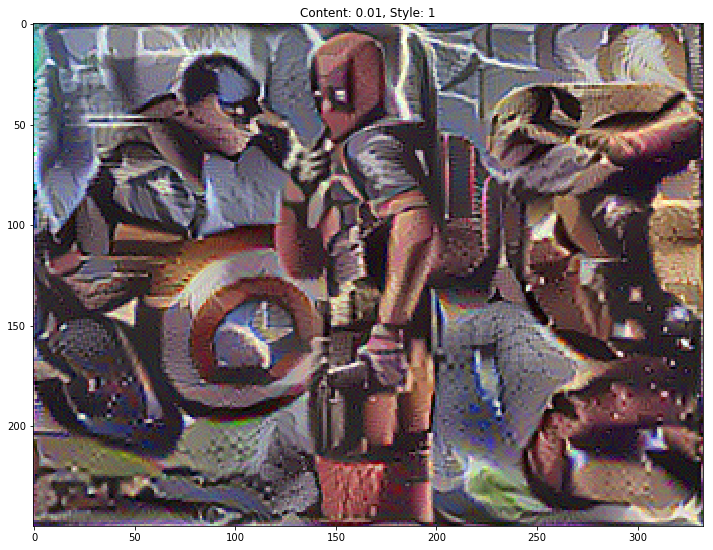

In [12]:
import glob

images = glob.glob('outputs/*')
# fig, axes = plt.subplots(3, 1, figsize=(6, 18))
# axes[0].imshow(plt.imread(CONTENT_IMAGE))
# axes[1].imshow(plt.imread(STYLE_IMAGE))
# axes[2].imshow(plt.imread(images[-1]))
# axes[2].set_title("Content: {}, Style: {}".format(CONTENT_WEIGHT, STYLE_WEIGHT))

plt.figure(figsize=(12, 12))
ax = plt.imshow(plt.imread(images[-1]))
ax.axes.set_title("Content: {}, Style: {}".format(CONTENT_WEIGHT, STYLE_WEIGHT))